# [CDAF] Atividade 2

## Nome: Thiago Pádua de Carvalho

## Matrícula: 2020007066

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xG pró, xG contra, e dif. xG.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [5]:
BRA1 = pd.read_csv('data/brazilian_league_20222.csv', sep=',')
BRA1.drop(columns=['Match Report', 'Notes', 'Attendance', 'Venue', 'Time', 'Referee', 'Day'], inplace=True)
BRA1 = BRA1.dropna()
display(BRA1)

,Wk,Date,Home,xG,Score,xG.1,Away
0,1.0,2022-04-09,Fluminense,1.6,0–0,0.1,Santos
1,1.0,2022-04-09,Atl Goianiense,1.4,1–1,1.2,Flamengo
2,1.0,2022-04-10,Coritiba,1.7,3–0,0.4,Goiás
3,1.0,2022-04-10,Atlético Mineiro,1.9,2–0,0.6,Internacional
4,1.0,2022-04-10,Botafogo (RJ),1.5,1–3,2.1,Corinthians
...,...,...,...,...,...,...,...
417,38.0,2022-11-13,Bragantino,0.9,0–1,0.6,Fluminense
418,38.0,2022-11-13,América (MG),2.1,1–1,0.5,Atl Goianiense
419,38.0,2022-11-13,Goiás,0.2,0–4,1.7,São Paulo
420,38.0,2022-11-13,Internacional,1.4,3–0,1.3,Palmeiras


In [6]:
def split_score(score):
    """
    splits match's score in format 'x-x' into two integer numbers.
    
    Args:
    score (str): Score in format 'x-x', where x is an integer number.
    
    Returns:
    Two integers: home score and away score
    """
    split_score = score.split("-")
    HS = int(split_score[0])
    AS = int(split_score[1])
    return HS, AS

In [7]:
def assign_xg(match, home=True):
    if home:
        xg_pro = match['xG']
        xg_con = match['xG.1']
    else:
        xg_pro = match['xG.1']
        xg_con = match['xG']
    return xg_pro, xg_con, xg_pro - xg_con

In [8]:
def rolling_average(teams, window=5):
    teams_dataframe = {}
    for team in teams:
        team_df = pd.DataFrame(columns=['xg_pro', 'xg_con', 'xg_diff', 'Game'])
        matches = BRA1.loc[(BRA1['Home'] == team) | (BRA1['Away'] == team)]
        game = 0
        for i, match in matches.iterrows():
            game += 1
            if match['Home'] == team:
                xg_pro, xg_con, xg_diff = assign_xg(match)
            else:
                xg_pro, xg_con, xg_diff = assign_xg(match, home=False)
            
            team_df.at[i, "xg_pro"] = xg_pro
            team_df.at[i, "xg_con"] = xg_con
            team_df.at[i, "xg_diff"] = xg_diff
            team_df.at[i, "Game"] = game

        team_df['XG_pro_RA'] = team_df['xg_pro'].rolling(window=window, win_type='triang').mean()
        team_df['XG_con_RA'] = team_df['xg_con'].rolling(window=window, win_type='triang').mean()
        team_df['XG_DIFF_RA'] = team_df['xg_diff'].rolling(window=window, win_type='triang').mean()

        teams_dataframe[team] = team_df
    
    return teams_dataframe

In [43]:
def plot_RA(team_dfs, teams_to_plot):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = ['green', 'red', 'blue', 'purple']
    #city highlighted more
    alphas = [1, 1, 1, 1]

    for club, color, alpha in zip(teams_to_plot, colors, alphas):
        ax.plot(team_dfs[club]['Game'],  team_dfs[club]['XG_pro_RA'], linewidth=2, linestyle='-',color=color, alpha = alpha, zorder = 2, label = club)

    #set title
    ax.set_title("Moving Averages - Brazilian League 2022", fontsize = 24, pad=20)
    #make visible ticks for beginning of each season
    #ax.set_xticks(np.arange(0, max(team_dfs["Liverpool"]['Game']) + 38, 38))
    #no text
    ax.set_xticklabels([])
    #make ticks in the middle
    ax.set_xticks(np.arange(1, 39))

    #set axis limits
    #ax.set_xlim(0, max(team_dfs["Liverpool"]['Game']) + 10)
    #ax.set_ylim(-0.1,3.2)
    #disable black ticks, but big text xaxis
    ax.tick_params(axis='x', color='white', which='both', labelsize = 20)
    #grey y ticks
    ax.tick_params(axis='y', color='grey', labelsize = 14)
    #add grid
    ax.grid(zorder = 1, linestyle = "--", alpha = 0.5)
    #disable spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #add axis labels
    ax.set_ylabel('Rolling Average Expected Goals Per Game', fontsize = 16,labelpad=10)
    ax.set_xlabel('Round', fontsize = 24, labelpad=10)
    #make legend
    plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left",fontsize=12, edgecolor='white')
    plt.show()

In [41]:
def RA_plot(league: pd.DataFrame, teams_to_plot: list):
    teams = league['Home'].unique()
    teams_df = rolling_average(teams, window=5)
    plot_RA(teams_df, teams_to_plot)

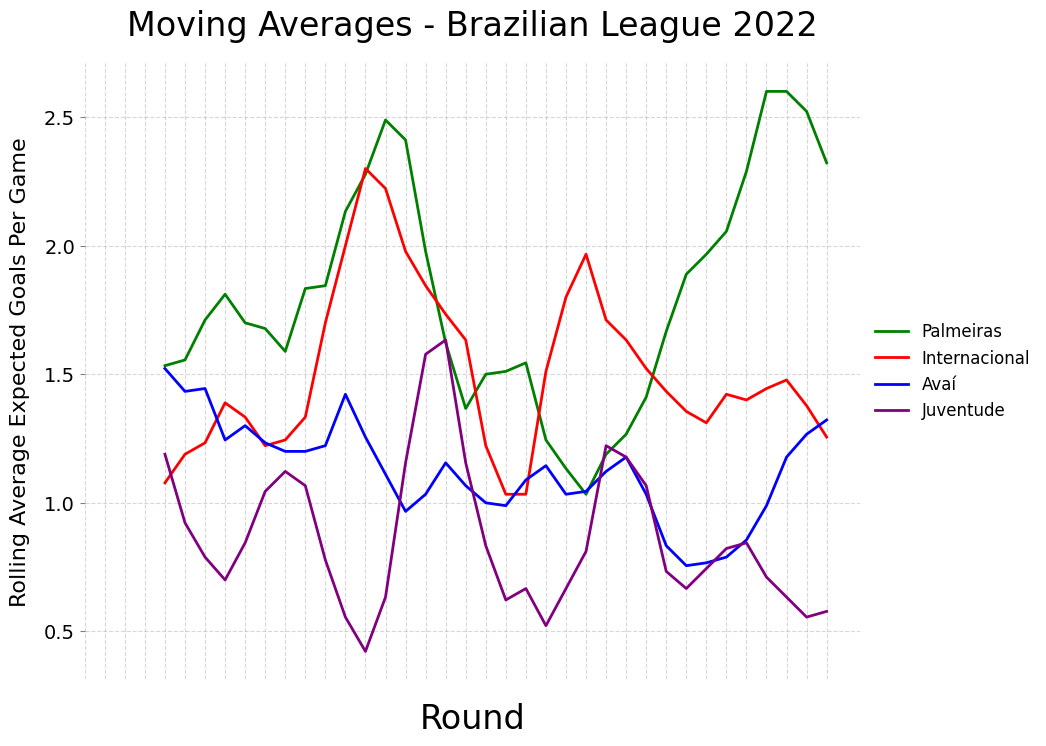

In [44]:
RA_plot(BRA1, ['Palmeiras', 'Internacional', 'Avaí', 'Juventude'])

https://soccermatics.readthedocs.io/en/latest/gallery/lesson5/plot_PointsMovingAverage.html#points-moving-average

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/latest/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?